# Performance Tests

## Time Bar Generation – `mlfinpy` vs `finmlkit`
Here we compare the performance of `mlfinpy` and `finmlkit` libraries for generating 1-minute time bars from raw trade data.

In [ ]:
# Install required libraries if needed
!pip install mlfinpy finmlkit matplotlib


In [ ]:
# download 1 month of raw trades data from binance
! curl -s "https://data.binance.vision/data/futures/um/monthly/trades/BTCUSDT/BTCUSDT-trades-2025-07.zip" -o "BTCUSDT-trades-2025-07.zip"
# download the corresponding checksum
! curl -s "https://data.binance.vision/data/futures/um/monthly/trades/BTCUSDT/BTCUSDT-trades-2025-07.zip.CHECKSUM" -o "BTCUSDT-trades-2025-07.zip.CHECKSUM"
# verify the checksum (MacOS)
! shasum -a 256 -c "BTCUSDT-trades-2025-07.zip.CHECKSUM"
# verify the checksum (Linux)
# sha256sum -c "BTCUSDT-trades-2025-07.zip.CHECKSUM"
# unzip the downloaded file
! unzip -o "BTCUSDT-trades-2025-07.zip"
! ls


In [1]:
# Import necessary libraries
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("BTCUSDT-trades-2025-07.csv")
df.head()

,id,price,qty,quote_qty,time,is_buyer_maker
0,6440230568,107087.3,0.002,214.1746,1751328000018,True
1,6440230569,107087.3,1.391,148958.4343,1751328004439,True
2,6440230570,107087.3,3.450,369451.1850,1751328004439,True
3,6440230571,107087.3,0.046,4926.0158,1751328004439,True
4,6440230572,107087.3,0.005,535.4365,1751328004439,True


## 1. Prepare Data for Both Libraries


In [3]:
# Prepare data for mlfinpy - requires [date_time, price, volume]
mlfinpy_data = df[['time', 'price', 'qty']].copy()
mlfinpy_data.columns = ['date_time', 'price', 'volume']
mlfinpy_data['date_time'] = pd.to_datetime(mlfinpy_data['date_time'], unit='ms')

# Display the prepared data
mlfinpy_data.head()


,date_time,price,volume
0,2025-07-01 00:00:00.018,107087.3,0.002
1,2025-07-01 00:00:04.439,107087.3,1.391
2,2025-07-01 00:00:04.439,107087.3,3.450
3,2025-07-01 00:00:04.439,107087.3,0.046
4,2025-07-01 00:00:04.439,107087.3,0.005


In [4]:
# Prepare data for finmlkit - using TradesData class
from finmlkit.bar.data_model import TradesData
from finmlkit.bar.kit import TimeBarKit

# Create a TradesData object
trades = TradesData(df.time.values, df.price.values, df.qty.values,
                    id=df.id.values, is_buyer_maker=df.is_buyer_maker.values,
                    preprocess=True)

print(f"TradesData processed {len(trades.data):,} records")
trades.data.head()


finmlkit.bar.data_model:324 | INFO | Inferred timestamp format: ms
finmlkit.bar.data_model:272 | INFO | Converting timestamp to nanoseconds units for processing...
finmlkit.bar.data_model:169 | WARNING | None | Found 15,593 discontinuities in trade IDs. This indicates missing trades.
finmlkit.bar.data_model:198 | INFO | Recorded 0 trade ID discontinuities with corresponding time intervals.
finmlkit.bar.data_model:238 | INFO | Merging split trades (same timestamps) on same price level...
finmlkit.bar.data_model:99 | INFO | TradesData prepared successfully.
TradesData processed 39,171,929 records


,timestamp,price,amount,side
datetime,,,,
2025-07-01 00:00:00.018,1751328000018000000,107087.3,0.002,-1
2025-07-01 00:00:04.439,1751328004439000000,107087.3,10.909,-1
2025-07-01 00:00:04.439,1751328004439000000,107087.2,0.004,-1
2025-07-01 00:00:04.439,1751328004439000000,107087.1,0.001,-1
2025-07-01 00:00:04.439,1751328004439000000,107086.7,0.002,-1


## 2. Generate 1-Minute Time Bars with Both Libraries


In [5]:
# 2.1 Generate 1-minute time bars using mlfinpy
from mlfinpy.data_structure import time_bars

frequency = 'MIN'  # 1-minute bars
start_time_mlfinpy = time.time()
mlfinpy_1min_bars = time_bars.get_time_bars(mlfinpy_data, resolution=frequency)
mlfinpy_time = time.time() - start_time_mlfinpy

print(f"\nmlfinpy execution time: {mlfinpy_time:.4f} seconds")
print(f"Generated {len(mlfinpy_1min_bars):,} time bars")
# mlfinpy_1min_bars.head()

Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Returning bars 


mlfinpy execution time: 116.7852 seconds
Generated 44,639 time bars


In [6]:
# 2.2 Generate 1-minute time bars using finmlkit
start_time_finmlkit = time.time()
tb1min_kit = TimeBarKit(trades, period=pd.Timedelta(minutes=1))
tb1min_klines = tb1min_kit.build_ohlcv()
finmlkit_time = time.time() - start_time_finmlkit

print(f"\nfinmlkit execution time: {finmlkit_time:.4f} seconds")
print(f"Generated {len(tb1min_klines):,} time bars")

finmlkit.bar.kit:27 | INFO | Time bar builder initialized with interval: 60.0 seconds.
finmlkit.bar.base:70 | INFO | Calculating bar open tick indices and timestamps...
finmlkit.bar.base:107 | INFO | OHLCV bar calculated successfully.
finmlkit.bar.base:120 | INFO | OHLCV bar converted to DataFrame.

finmlkit execution time: 1.8961 seconds
Generated 44,640 time bars


Quite impressive, right? But guess what, this can be **even faster**! The first run contains the compilation time, so let's run it again to see the real performance.

In [9]:
# 2.2 Generate 1-minute time bars using finmlkit
start_time_finmlkit = time.time()
tb1min_kit = TimeBarKit(trades, period=pd.Timedelta(minutes=1))
tb1min_klines = tb1min_kit.build_ohlcv()
finmlkit_time = time.time() - start_time_finmlkit

print(f"\nfinmlkit execution time: {finmlkit_time:.4f} seconds")
print(f"Generated {len(tb1min_klines):,} time bars")
#tb1min_klines.head()

finmlkit.bar.kit:27 | INFO | Time bar builder initialized with interval: 60.0 seconds.
finmlkit.bar.base:70 | INFO | Calculating bar open tick indices and timestamps...
finmlkit.bar.base:107 | INFO | OHLCV bar calculated successfully.
finmlkit.bar.base:120 | INFO | OHLCV bar converted to DataFrame.

finmlkit execution time: 0.1728 seconds
Generated 44,640 time bars


## 3. Performance Comparison


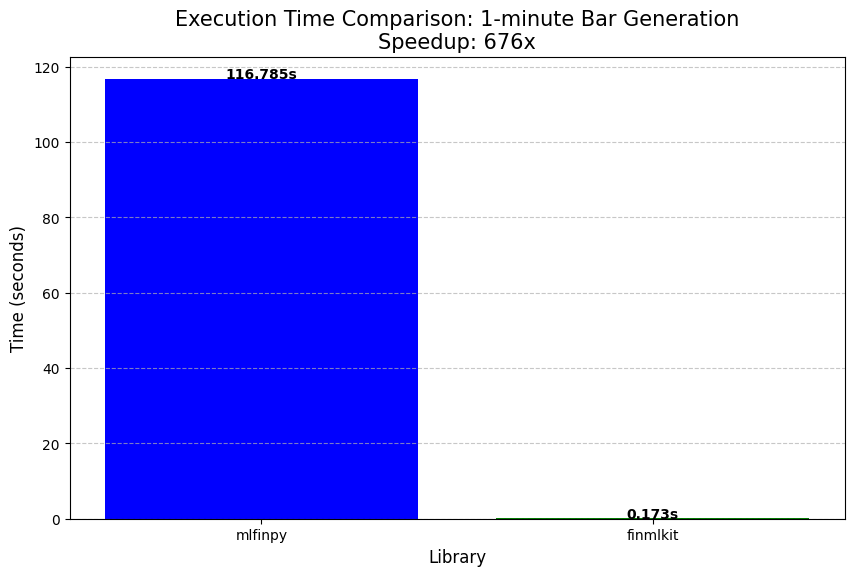

In [10]:
# Compare execution time
times = [mlfinpy_time, finmlkit_time]
libraries = ['mlfinpy', 'finmlkit']

plt.figure(figsize=(10, 6))
plt.bar(libraries, times, color=['blue', 'green'])
plt.title(f'Execution Time Comparison: 1-minute Bar Generation\nSpeedup: {round(mlfinpy_time/finmlkit_time)}x', fontsize=15)
plt.ylabel('Time (seconds)', fontsize=12)
plt.xlabel('Library', fontsize=12)

# Add time values on top of bars
for i, v in enumerate(times):
    plt.text(i, v + 0.1, f"{v:.3f}s", ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
